## Training a sentiment analysis classifier based on supervised machine learning algorithms

In [1]:
import string

import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
stop_words = set(stopwords.words('spanish'))

In [4]:
def tokenizer(text):
    tt = TweetTokenizer()
    return tt.tokenize(text)

### Loading labeled tweets

In [5]:
# Dataset loaded from: https://docs.google.com/spreadsheets/d/11_E2ngsEOyTQwbwVVRHY5urzFF95BQCV/edit#gid=1788161364
tweets_df = pd.read_csv('./data/tweetsEntrenamiento.csv', sep = ',')

In [6]:
tweets_df.shape

(296, 2)

In [7]:
tweets_df.head()

,full_text,sentiment
0,@Nata_Salud @Sandrag69 @AndresMejiaV ¡Hola Natalia! Te invitamos a descubrir tu #MatchPresidencial aquí: https://t.co/0E1tZKypTK,neutral
1,@supershadai @Registraduria Quien o que institución en Colombia atiende los reclamos al fraude electoral?\nPorque no suspender a al registrador que ya la defeco en las elecciones de senado y camara.\nHay una desconfianza general en cuanto a las presidenciales.\nEstán provocando una respuesta violenta.,negative
2,@BOLIBAR2 @AndresPastrana_ @santiagoangelp Un poco tarde con las elecciones encima… mal para Colombia,negative
3,"No encontraron otra alternativa que llenar de miedo a Colombia, utilizan sus paramilitares para ganar elecciones. Es ahora o nunca @petrogustavo",positive
4,"@BOLIBAR2 @CNE_COLOMBIA @AndresPastrana_ Aquí no va a pasar nada, y petro de va a robar las elecciones presidenciales y el país",negative


In [8]:
tweets_df['sentiment'].value_counts(dropna = False, normalize = True)

negative    0.702703
neutral     0.233108
positive    0.064189
Name: sentiment, dtype: float64

### Leaving out unlabeled texts, this data is not useful for training or validating a supervised model

In [9]:
# Removing  unlabeled tweets
tweets_labeled_df = tweets_df.loc[tweets_df['sentiment'].notnull()]

In [10]:
tweets_labeled_df.shape

(296, 2)

In [11]:
tweets_unlabeled_df = tweets_df.loc[tweets_df['sentiment'].isnull()]

In [12]:
tweets_unlabeled_df.shape

(0, 2)

In [13]:
# Scenario 3: Treating neutral as positive classes
tweets_labeled_df['sentiment'] = tweets_labeled_df['sentiment'].replace({'neutral':'positive'})

### Splitting train and test datasets

In [14]:
X_train, X_test, y_train, y_test = train_test_split(tweets_labeled_df['full_text'], tweets_labeled_df['sentiment'], test_size = 0.2, stratify = tweets_labeled_df['sentiment'], random_state = 1)


In [15]:
X_train.shape

(236,)

In [16]:
pd.Series(y_train).value_counts(normalize = True)

negative    0.70339
positive    0.29661
Name: sentiment, dtype: float64

In [17]:
X_test.shape

(60,)

In [18]:
pd.Series(y_test).value_counts(normalize = True)

negative    0.7
positive    0.3
Name: sentiment, dtype: float64

### Vectorizing texts

In [19]:
bow = CountVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [20]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [21]:
X_bow = bow.fit_transform(X_train)

In [22]:
X_tfidf = tfidf.fit_transform(X_train)

### Training and evaluating a model using BOW

In [23]:
model = KNeighborsClassifier(n_neighbors=3)

In [24]:
model.fit(X_bow, y_train)

KNeighborsClassifier(n_neighbors=3)

In [25]:
y_train_bow_predict = model.predict(X_bow)
y_test_bow_predict = model.predict(bow.transform(X_test))

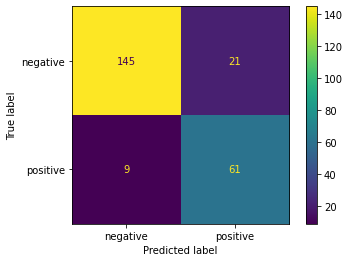

In [26]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

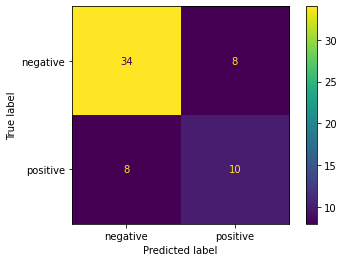

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [28]:
# Metrics calculation for more than two classes
print('Precision:', precision_score(y_test, y_test_bow_predict, average = None))
print('Recall:', recall_score(y_test, y_test_bow_predict, average = None))
print('F1:', f1_score(y_test, y_test_bow_predict, average = None))

Precision: [0.80952381 0.55555556]
Recall: [0.80952381 0.55555556]
F1: [0.80952381 0.55555556]


### Training and evaluating a model using TF-IDF

In [29]:
model = KNeighborsClassifier(n_neighbors=3)

In [30]:
model.fit(X_tfidf, y_train)

KNeighborsClassifier(n_neighbors=3)

In [31]:
y_train_tfidf_predict = model.predict(X_tfidf)
y_test_tfidf_predict = model.predict(bow.transform(X_test))

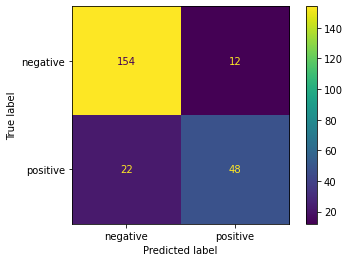

In [32]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

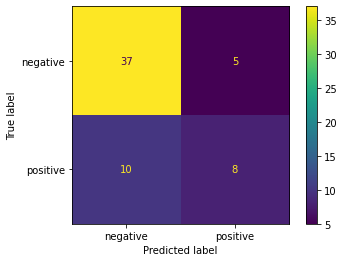

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [34]:
# Metrics calculation for more than two classes
print('Precision:', precision_score(y_test, y_test_tfidf_predict, average = None))
print('Recall:', recall_score(y_test, y_test_tfidf_predict, average = None))
print('F1:', f1_score(y_test, y_test_tfidf_predict, average = None))

Precision: [0.78723404 0.61538462]
Recall: [0.88095238 0.44444444]
F1: [0.83146067 0.51612903]


### How interpret the results?

### Analyzing errors Bag of Words

In [35]:
error_df1 = pd.concat(
    [ pd.concat([X_test, y_test ], axis = 1).reset_index(),
    pd.Series(y_test_bow_predict) ]
, axis = 1).rename(columns = { 'sentiment': 'actual', 0: 'predicted' })

error_df1.drop('index', inplace = True, axis = 1)

In [36]:
error_df1.shape

(60, 3)

In [37]:
error_df1.loc[error_df1['actual'] != error_df1['predicted']].head(20)

,full_text,actual,predicted
8,"@tinagus2000 Evidentemente la persecución judicial, la aceleración de cosas, las trabas del @cnegobec para la inscripción , el viaje de la fiscal a Colombia y el papel de otras instituciones influyeron en la victoria de Lasso. Al otro candidato lo desgastaron, mucha antes de las elecciones.",positive,negative
14,"@RICHENAO El @PactoHistorico de @petrogustavo , a @CNE_COLOMBIA @Doris_MendezC jamás los tendría en Cuenta cómo jurados o vigilantes en unas elecciones",negative,positive
19,@FicoGutierrez Señores quien creo la AUC en colombia. Ahora se les salieron de las manos o es simplemente una estrategia para ganar las elecciones creando el caso en el país y echándole las culpas a otros. De verdad que somos un país donde todo lo olvidamos por eso estamos como estamos.,negative,positive
22,Petro se está convirtiendo en un peligro para la seguridad nacional de Colombia. \n\nhttps://t.co/86BnUWZIVc,negative,positive
24,"@condeza6 @Gonzalo00333993 @Pura_Miel @Registraduria @CNE_COLOMBIA @moecolombia @PGN_COL Coño que porquería de país , acaso la procuradora se revolcó con el registrador y le tomo fotos y videos que la tiene chantajeada o que , que carajos es lo que esa vieja está esperando que se forme un mierdero el día de las elecciones?",positive,negative
26,Colombia. País de las jugaditas...\n\nCon o sin Ley de garantías el Uribismo siempre ha encontrado y encontrará la manera de amañar elecciones y comprar votos.,negative,positive
29,@CNE_COLOMBIA No se roben las elecciones para favorecer al bandido guerrillero Petro.,negative,positive
31,Estos son los tarjetones con los que Colombia ha votado a la presidencia en 28 años:\n\nhttps://t.co/7jcyCwQuni,positive,negative
32,Elecciones en Colombia: el silencio que decidirá al ganador https://t.co/lHH5JFvDd9,positive,negative
35,"Ya no me quedan dudas que el ""paro armado"" fue orquestado desde el Ubérrimo! Días paramilitares quemando buses, disparando contra los civiles y todo el terrorismo CON la indiferencia CÓMPLICE de @Diego_Molano Y @COMANDANTE_EJC Campaña política sangrienta.\nhttps://t.co/99pr8DragM",negative,positive


### Analyzing errors TF-IDF

In [38]:
error_df2 = pd.concat(
    [ pd.concat([X_test, y_test ], axis = 1).reset_index(),
    pd.Series(y_test_tfidf_predict) ]
, axis = 1).rename(columns = { 'sentiment': 'actual', 0: 'predicted' })

error_df2.drop('index', inplace = True, axis = 1)

In [39]:
error_df2.shape

(60, 3)

In [40]:
error_df2.loc[error_df2['actual'] != error_df2['predicted']].head(20)

,full_text,actual,predicted
8,"@tinagus2000 Evidentemente la persecución judicial, la aceleración de cosas, las trabas del @cnegobec para la inscripción , el viaje de la fiscal a Colombia y el papel de otras instituciones influyeron en la victoria de Lasso. Al otro candidato lo desgastaron, mucha antes de las elecciones.",positive,negative
11,"Gracias a los Acuerdos de paz de La Habana en 2018 Colombia tuvo las elecciones más pacíficas de su historia. \n\nUribismo nos devolvió a elecciones en medio de guerra, paros armados y violaciones masivas a los ddhh.",negative,positive
12,@ozuismysenpai Pillá https://t.co/fnZFeKA3fz,positive,negative
15,Lo he analizado toda la mañana y verdaderamente la época de elecciones en Colombia es TERRORÍFICA.,negative,positive
16,"@correawilly @CNE_COLOMBIA Leído los documentos provenientes de cada circunscripción territorial y de la internacional, se declaró el resultado de la Cámara por circunscripción internacional y se recibieron más de 1000 solicitudes y reclamaciones respecto de elecciones de Senado y Cámaras étnicas, …",positive,negative
17,¡Viva Petro!\nColombia | Petro anuncia que si gana restablecerá las relaciones diplomáticas y consulares con Venezuela @InfoNodal https://t.co/VjYoQsWoY1,negative,positive
22,Petro se está convirtiendo en un peligro para la seguridad nacional de Colombia. \n\nhttps://t.co/86BnUWZIVc,negative,positive
23,Me salió esto 😅\n\nhttps://t.co/TJokUajStC,positive,negative
24,"@condeza6 @Gonzalo00333993 @Pura_Miel @Registraduria @CNE_COLOMBIA @moecolombia @PGN_COL Coño que porquería de país , acaso la procuradora se revolcó con el registrador y le tomo fotos y videos que la tiene chantajeada o que , que carajos es lo que esa vieja está esperando que se forme un mierdero el día de las elecciones?",positive,negative
31,Estos son los tarjetones con los que Colombia ha votado a la presidencia en 28 años:\n\nhttps://t.co/7jcyCwQuni,positive,negative
